# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Benjamin Chooyin, Estelle McCool, Brad Wang, Alyssa Heggison (Group 26) 

## General Setup

In [269]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn

In [270]:
# Load data
data = pd.read_csv("the_office.csv")
data = pd.DataFrame(data)

#Load additional data
data_kaggle = pd.read_csv('datasets/the_office_kaggle.csv')
data_kaggle = pd.DataFrame(data_kaggle)

data_scripts = pd.read_csv('datasets/the_office_lines_scripts.csv')
data_scripts = pd.DataFrame(data_scripts)

Datasets that could be used to count dialogue

https://data.world/abhinavr8/the-office-scripts-dataset/workspace/file?filename=the-office-lines+-+scripts.csv

https://www.kaggle.com/datasets/chazzer/the-office-quotes-dataset?select=talking_head.csv

After making sure that all the necessary libraries or submodules are uploaded here, please follow the given skeleton to create your project report. 
- Your completed assignment must follow this structure 
- You should not add or remove any of these sections, if you feel it is necessary you may add extra subsections within each (such as *2.1. Encoding*). 

**Do not forget to remove the instructions for each section in the final document.**

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

In this report we outline the machine learning techinques we used to gain insight into the most important factors for an episode of the office to have a 'good' imdb rating. By 'good' we mean factors that by their inclusion/omission resulted in the greatest possible increases in imdb rating. We focused on factors that were actionable, as if a factor was a good indicator of score, but out of the production teams control, they will have not gained insight from this analysis. 

Then to explore the possible machine learning apporaches we first used just linear regression as a baseline to compare to, and then explored 3 possible approaches that could improve upon it. We looked at a ridge rigression, polynomial regression, and a polynomial-ridge regression. We found that the ridge regression was the most effective and we used this to guide our recommendations. We then used our model to examine which factors had the biggest impact on the overall rating of the episode, we found these were...


## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

Firstly we do exploratory data analysis to get an overview of the data

Here is an elementary look at some random rows to check the data types of the columns and any missing values in data.

In [299]:
data.sample(5)

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
98,6,9,Double Date,Seth Gordon,Charlie Grandy,8.2,1709,2009-11-05,367,54,3293,19,Andy;Angela;Creed;Dwight;Erin;Jim;Kelly;Kevin;...
118,7,4,s*x Ed,Paul Lieberstein,Paul Lieberstein,7.9,1650,2010-10-14,321,62,3141,30,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kelly...
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
60,4,14,Chair Model,Jeffrey Blitz,B.J. Novak,8.1,2095,2008-04-17,220,61,2680,20,Andy;Angela;Creed;Dwight;Jim;Kevin;Michael;Osc...
27,2,22,Casino Night,Greg Daniels,Steve Carell,9.3,3644,2006-05-11,368,28,3204,23,Angela;Creed;Darryl;Dwight;Jim;Kelly;Kevin;Mer...


In [300]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


A few observations could be made.

1. The data contains numerical values and strings, where the latter needs to be encoded to be utilised by the model.
2. The columns $\texttt{season}$, $\texttt{episode}$ and $\texttt{total\_votes}$ are not controllable in terms of film producing, and so should not be considered as inputs of the final model. However, we could still test their correlations with the rating. 
3. The column $\texttt{air\_date}$ needs to be transformed (e.g. into the number of days from the eariliest airdate) to be used as a numerical variable. 
4. The strings of the columns $\texttt{writers}$ and $\texttt{main\_chars}$ are writer/character names separated by $\textbf{;}$, and we would split them and then encode the apprearance of each individual writer/character. 
5. The name of a episode might have effects on the number of people who decide to watch it, and thereby the number of votes it gets. However, considering we have a relatively small dataset (186 observations), the analysis of the effects of episode names is not practical here. (If we wanted to take this into account we could do further research on natural language processing and semantic analysis)
6. There are no missing values in the data.

We further take a look at the scaling and distributing features of the data.

In [301]:
data.describe()

,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,5.462366,12.478495,8.250538,2129.543011,296.397849,50.150538,3053.510753,20.693548
std,2.398464,7.233710,0.535168,790.787586,81.998568,23.941797,799.271717,5.092407
min,1.000000,1.000000,6.700000,1393.000000,131.000000,11.000000,1098.000000,12.000000
25%,3.000000,6.000000,7.900000,1628.500000,255.250000,34.000000,2670.250000,17.000000
50%,6.000000,12.000000,8.200000,1954.000000,281.000000,46.000000,2872.500000,20.000000
75%,7.750000,18.000000,8.600000,2385.000000,314.500000,60.000000,3141.000000,23.000000
max,9.000000,28.000000,9.700000,7934.000000,625.000000,166.000000,6076.000000,54.000000


In [302]:
data.corr()

,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char
season,1.000000,0.098716,-0.397731,-0.444398,0.115649,0.228935,0.146717,0.413508
episode,0.098716,1.000000,0.179985,0.020161,0.034908,0.125925,0.055552,0.184197
imdb_rating,-0.397731,0.179985,1.000000,0.653973,0.348994,0.226286,0.337212,0.091992
total_votes,-0.444398,0.020161,0.653973,1.000000,0.205062,0.182462,0.265325,0.178324
n_lines,0.115649,0.034908,0.348994,0.205062,1.000000,0.487551,0.915959,0.416188
n_directions,0.228935,0.125925,0.226286,0.182462,0.487551,1.000000,0.511985,0.350052
n_words,0.146717,0.055552,0.337212,0.265325,0.915959,0.511985,1.000000,0.480967
n_speak_char,0.413508,0.184197,0.091992,0.178324,0.416188,0.350052,0.480967,1.000000


Below we created a pair plot, in which each pair of variables is plotted against eachother to observe any possible relationships. We look for variables that are highly correlated and so might provide very similar information to the model, and so could be removed. We also consider which variables appear to have some relationship with imdb_rating and hence might be useful as predictors. 

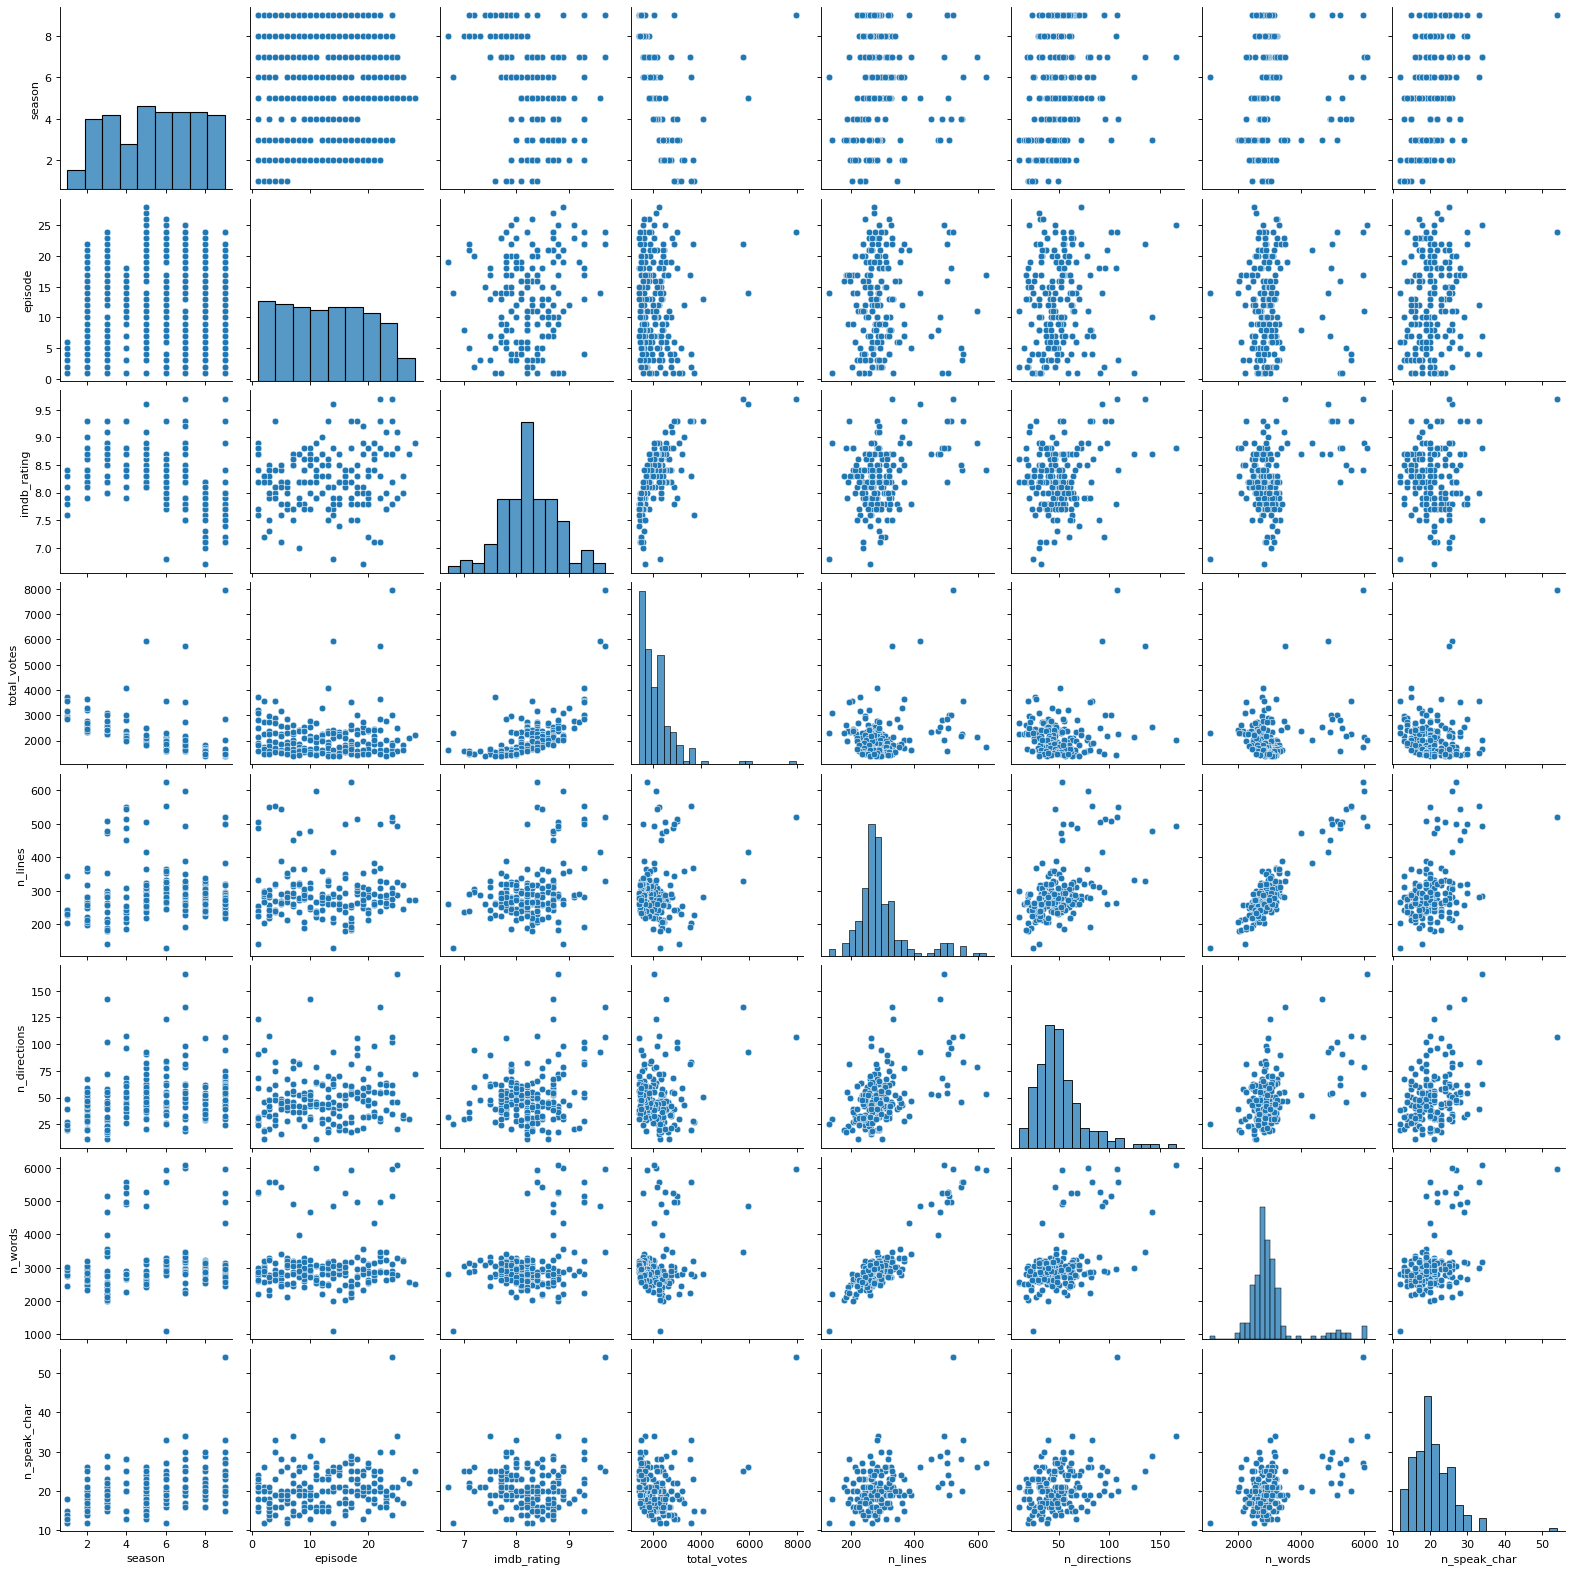

In [303]:
# The data contains 186 episodes with a mean ammount of votes 2130 per episode and a mean rating of 8.25. 
sns.pairplot(data)

The described statictics show that numerical variables are of quite different scales, which implies normalisation might need to be performed. Many of these pairplots contain little information but there are some interesting trends. 

1. Season 8 was particularly unpopular.
2. The ratings are normally distributed.
3. The number of lines and number of words are strongly correlated so we may not need both variables. 
4. There seems to be some quadratic correlation between the total votes and the imbd rating.

To make our model as practical as possible we have made some changes to the original data set.
Firstly we cleaned up the data set and removed typos in the directors names. 

We decided to remove several columns of the data that we can't use in the final recommendations as detailed below:

It is not possible for the directors to release the episode in the past and the year of release is not easy to control so we dropped air date, however, we replaced this with air_season which showed some potential correlation, such as summer episodes performing better.

We droped number of votes on imbd rating because although this had a strong quadratic correlation with imdb rating the directors have no control of how many people vote on the episode. We did briefly consider using number of votes as a response variable instead of as a feature but found this didnt work very well. 

We removed Number of words to streamline the model because it was highly correlated to number of lines.

We also dropped episode season because the special will have to be in its own season 10 so there is no point recomending a season for the special to be in.



In [328]:
'''
   Data Formatting
'''
data_numeric = data.copy()
pd.options.mode.chained_assignment = None 


'''
   The imported data was seperated by semicolons so I have 
   replaced these with commas to make the data useable
'''
#Character column
for i in range(0,len(data.main_chars)):
   data_numeric.main_chars[i] = data.main_chars[i].split(';')
#Writer column
for i in range(0,len(data.writer)):
   data_numeric.writer[i] = data.writer[i].split(';')
#Director column
for i in range(0,len(data.director)):
   data_numeric.director[i] = data.director[i].split(';')



'''
   One hot encoding all of the categorical columns so they can be used
'''
#Import function for multi variable one hot encoder 
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer() #Reference this documentation at the end

#Directors
encoded_directors = pd.DataFrame(mlb.fit_transform(data_numeric['director']), columns= mlb.classes_)

#Writer
encoded_writers = pd.DataFrame(mlb.fit_transform(data_numeric['writer']), columns= mlb.classes_)

#One hot encoding the main characters
encoded_characters = pd.DataFrame(mlb.fit_transform(data_numeric["main_chars"]), columns= mlb.classes_)

In [329]:
'''
A function to remove duplicate typos in strings.
parameters:
data, the one hot encoded data frame to remove typos from
correct- the correct spelling of the string
typo- the typo spelling of the string
'''
def remove_typos(data, correct, typo):
    removed = np.zeros(shape = (186))
    data[correct] = encoded_directors[correct] + data[typo]
    data[typo] = removed
    return data.drop(typo, axis = 1)

In [330]:
#Removing all typos in the directors column
encoded_directors = remove_typos(encoded_directors,'Greg Daniels', 'Greg Daneils')
encoded_directors = remove_typos(encoded_directors,'Charles McDougal', 'Charles McDougall')
encoded_directors = remove_typos(encoded_directors,'Claire Scanlon', 'Claire Scanlong')
encoded_directors = remove_typos(encoded_directors,'Ken Whittingham', 'Ken Wittingham')
encoded_directors = remove_typos(encoded_directors,'Paul Lieberstein', 'Paul Lieerstein')

We suspected that the large number of columns for directors and writers might be problematic for our model so we have some code below that combines the directors that only did a few episodes into a single column 'other director'. We did a similar thing for writer.

In [331]:
# Add suffix
encoded_directors = encoded_directors.add_suffix(' dir')
encoded_writers = encoded_writers.add_suffix(' wri')


'''
Merge the less frequent directors/writers
'''
# Filter out those directors
other_directors = encoded_directors.columns[encoded_directors.sum() < 5]

# Sum to a new column 'Other directors'
encoded_directors['Other directors'] = encoded_directors[other_directors].sum(axis=1)

# Drop those directors
encoded_directors.drop(other_directors, axis=1, inplace=True)

# Filter out those writers
other_writers = encoded_writers.columns[encoded_writers.sum() < 5]

# Sum to a new column 'Other writers'
encoded_writers['Other writers'] = encoded_writers[other_writers].sum(axis=1)

# Drop those writers
encoded_writers.drop(other_writers, axis=1, inplace=True)


'''
   Joining the One hot encoded columns with the original data frame and removing the raw data
'''
data_numeric.drop(['director', 'writer'], axis=1, inplace=True)

data_numeric = data_numeric.join(encoded_writers)
data_numeric = data_numeric.join(encoded_directors)


In [332]:
'''
   Construct season variables and time-period in year from the earliest air_date
'''
# Manually specify the month for each season according to 
# https://web.archive.org/web/20090327085605/http://www.knmi.nl/cms/content/22141/begin_van_de_lente
seasons = {'spring': (3, 4, 5), 
           'summer': (6, 7, 8),
           'autumn': (9, 10, 11),
           'winter': (12, 1, 2)}

for season in seasons:
   # For each season create a binary variable
   data_numeric[season] = 0
   
   for i in range(len(data_numeric)):
      # For each data point check the month info to confirm the season
      data_numeric[season][i] = int(int(data_numeric['air_date'][i].split('-')[1]) in seasons[season])

data_numeric['air_year'] = 0
for i in range(len(data_numeric)):   
   # For each data point extract the year info
   data_numeric['air_year'][i] = int(data_numeric['air_date'][i].split('-')[0])

# Since we want to capture long-term effect, we could simply make the year start with 0
data_numeric['air_year'] = data_numeric['air_year'] - data_numeric['air_year'].min()


'''
   Create the only id 'season_episode' for later extra data merge
   and remove repeated columns
'''
data_numeric['season_episode'] = 's' + data_numeric['season'].astype(str) + '_e' + data_numeric['episode'].astype(str)
data_numeric.drop(['season', 'episode', 'air_date'], axis=1, inplace=True)

''' Dropping highly-correlated variable'''
data_numeric.drop(['n_words'], axis=1, inplace=True)

pd.set_option('display.max_columns', None)

For the main character information, initially we directly one-hot encoded them to create binary variables for each character to record his/her presence in a certain episode. However, we obtain an extra dataset which contains the scripts of the characters in each episode, and we then realise that instead of one-hot encoding, we could transform the scripts into the number of words said by a certain character in each episode. This does not only give the presence information (i.e. word_counts $= 0$ or $>0$) of the characters, but also quantifies how much they are presented, which might be helpful in figuring out more detailed popularities of them. We did a basic data exploration on that new dataset (we omit it in the final report) and have the following observations.

1. There are 11 out of 186 episodes in our data of which the new dataset does not contain information. We could assign them with the average value of the other data points.
2. In the column of the scripts of the characters, the entries also contain some scene descriptions like the action and mood settings of the characters. We decided to include them in word counts as well because the detailed script design of a character also indicates a high level of presence.
3. There are 129 out of 59909 script records simultaneously said by more than one character, that is, the corresponding character record is in the form of 'character_A and character_B'. Considering that this proportion is really small, we decided not to deal with this and simply ignore the 129 data points.
4. The scripts are from more than 600 unique speakers, and by experimenting including different numbers of speakers, we decided only to use the scripts for the 17 characters presented in the original data. 

In [333]:
import string
from tqdm import tqdm
'''
    Concatenate datasets of character scripts to our data
    in a way such that each character has a word count for each episode
'''
# Create the id 'season_episode' according to the earlier definition
data_scripts['season_episode'] = 's' + data_scripts['season'].astype(str) + '_e' + data_scripts['episode'].astype(str)

# Create dataframe to contain the word counts
num_scripts = pd.DataFrame({
    'season_episode': data_numeric['season_episode'].unique()
})

# Only consider the charaters appeared in the original data
for char in tqdm(encoded_characters.columns):
    # Filter the scripts for each character
    d_slice1 = data_scripts[data_scripts['speaker'] == char]
    
    # initialise the word counts column for that character
    num_scripts[f'words_{char}'] = 0
    
    for s_e in num_scripts['season_episode']:
        # Filter the scripts for each episode
        d_slice2 = d_slice1[d_slice1['season_episode'] == s_e]
        
        words_count = 0
        for sentence in d_slice2['line_text']:
            # Count the numebr of words in each line with punctuations ignored
            words_count += sum(word.strip(string.punctuation).isalpha() for word in sentence.split())
            
        num_scripts[f'words_{char}'][num_scripts['season_episode']==s_e] = words_count

# Merge the datasets with season_episode as the matching key
data_numeric = data_numeric.set_index('season_episode').join(num_scripts.set_index('season_episode'))

# Delete the original character column
data_numeric.drop(['main_chars'], axis=1, inplace=True)

100%|██████████| 17/17 [00:04<00:00,  4.20it/s]


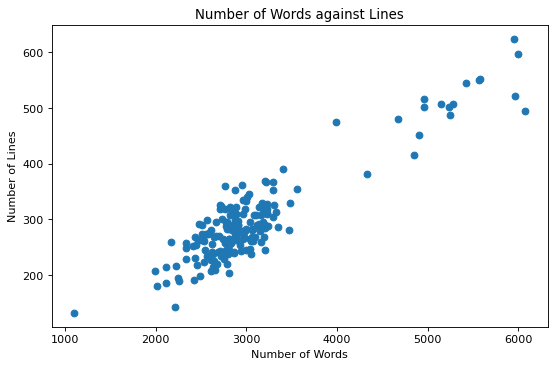

In [334]:
#Plotting two correlated variables on a larger plot
fig1, ax1 = plt.subplots()
ax1.scatter(data['n_words'], data['n_lines'])
ax1.set_xlabel("Number of Words")
ax1.set_ylabel("Number of Lines")
ax1.set_title("Number of Words against Lines")
plt.show()

We noticed than number of words and number of lines appeared to have a positive linear relationship, and have very high correlation coefficient of 0.91. We decided to remove one of these predictors to simplify our final model, and opted to drop number of words because it has slightly lower correlation coefficent when paired with IMDB rating. 

We noticed that there seemed to be a few episodes with significantly higher or lower ratings than the mean. A box-plot shows that some of these observations fall outwith the upper and lower boundaries of the 75th and 25th quartiles respectively (Episodes with rating of 9.7 or 6.7).

We manually searched the data file to identify these obesrvations but decided not to remove them. Removing these might provide a better model for predicting the rating of more 'average' episodes. But in the case that the studio aims for a very high rating we definitely want to include points in this range in our model. If the studio decided they wanted to identify qualities that would give a better guarantee of a more average rating, then removing these points could be considered. 

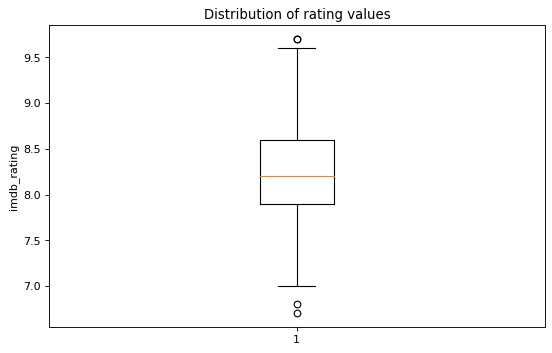

"\ndata_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Goodbye, Michael')], axis=0, inplace=True)\ndata_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Finale')], axis=0, inplace=True)\ndata_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Get The Girl')], axis=0, inplace=True)\ndata_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='The Banker')], axis=0, inplace=True)\n"

In [335]:
#Outlier removal 
#Plotting a box plot of ratings to view any outlier values 
fig2, ax2 = plt.subplots()
ax2.boxplot(data['imdb_rating'] )
ax2.set_ylabel("imdb_rating")
ax2.set_title("Distribution of rating values")
plt.show()

#We can see that there are a few outlier values
'''
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Goodbye, Michael')], axis=0, inplace=True)
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Finale')], axis=0, inplace=True)
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='Get The Girl')], axis=0, inplace=True)
data_numeric.drop(data_numeric.index[(data_numeric['episode_name']=='The Banker')], axis=0, inplace=True)
'''

As mentioned above, we decided not to include total_votes as a predictor, because it's not something the filming team can control. However, we considered that it might be a possibility to find a model to predict total_votes instead of rating. The variables have a high correlation coefficient of 0.65 and apparent quadratic relationship shown in the plot below. Total votes might be a good measure of the fame and emotion-provoking nature of an episode which it makes sense could relate to how good the episode is. So, we thought that predicting total_votes might be of benefit if this model ended up having stronger predictive ability than our best model predicting rating directly. We explored this briefly in Section 3 by following the same process to create a model for total_votes as we used to predict imdb_rating. However we didn't see any improvement in the performance metrics and so decided not to purse this idea further.  

Additionally, if we had chosen to use this as our primary model we would have needed to be careful not to infer causation. We don't know that there aren't other related variables which cause an apparent relationship between total votes cast and rating. It might be that highly-rated episodes just have more votes because they are more famous, or because people are excited to share their views on their favourite program. 

Text(0.5, 1.0, 'Total Votes against Rating')

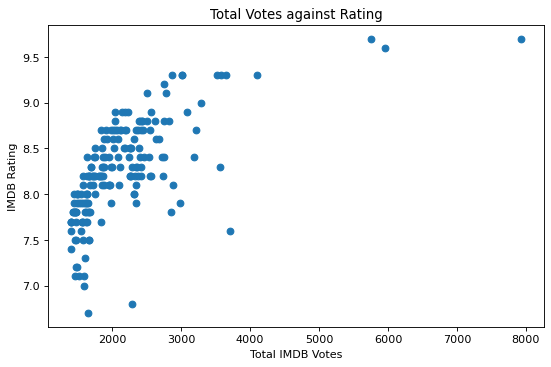

In [336]:
# We plot an individual plot of total_votes against imdb_rating

fig1, ax1 = plt.subplots()
ax1.scatter(data['total_votes'], data['imdb_rating'])
ax1.set_xlabel("Total IMDB Votes")
ax1.set_ylabel("IMDB Rating")
ax1.set_title("Total Votes against Rating")

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**


We first considered a linear regression model, as if an easily interpretable model could give us the insight we needed, this would allow us to give well informed recommendations to the office production team. 

We began by scaling the numerical features because we noticed that there was a wide range of magnitudes of values. Then we split the data into two sets - one on which to train our model and another on which to test it's predictive ability. 

In [337]:
data_numeric.sample(5)

,episode_name,imdb_rating,total_votes,n_lines,n_directions,n_speak_char,Aaron Shure wri,B.J. Novak wri,Brent Forrester wri,Charlie Grandy wri,Daniel Chun wri,Gene Stupnitsky wri,Greg Daniels wri,Halsted Sullivan wri,Jennifer Celotta wri,Justin Spitzer wri,Lee Eisenberg wri,Michael Schur wri,Mindy Kaling wri,Paul Lieberstein wri,Warren Lieberstein wri,Other writers,B.J. Novak dir,Charles McDougal dir,David Rogers dir,Greg Daniels dir,Jeffrey Blitz dir,Ken Kwapis dir,Ken Whittingham dir,Matt Sohn dir,Paul Feig dir,Paul Lieberstein dir,Randall Einhorn dir,Other directors,spring,summer,autumn,winter,air_year,words_Andy,words_Angela,words_Creed,words_Darryl,words_Dwight,words_Erin,words_Jim,words_Kelly,words_Kevin,words_Meredith,words_Michael,words_Oscar,words_Pam,words_Phyllis,words_Ryan,words_Stanley,words_Toby
season_episode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s9_e4,Work Bus,7.9,1551,320,75,19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,7,480,53,22,54,655,107,611,0,112,33,0,107,185,23,0,58,13
s5_e7,Customer Survey,8.5,2018,367,78,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,3,559,27,14,0,139,0,157,133,12,25,1005,227,173,7,146,12,0
s1_e2,Diversity Day,8.3,3566,203,20,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,4,0,0,355,0,386,11,73,0,2282,67,147,0,82,20,15
s5_e22,Dream Team,8.3,1863,309,55,21,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,4,363,0,0,0,866,0,305,2,6,0,1184,0,153,29,46,8,0
s2_e18,Take Your Daughter to Work Day,8.3,2415,264,52,25,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,103,26,37,361,0,212,76,65,37,1207,24,233,3,67,126,80


In [383]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Dropping text and response variables from our dataframe
X = data_numeric.drop(['imdb_rating', 
                       'episode_name', 
                       'total_votes'], axis = 1)
y = data_numeric['imdb_rating']


# Selecting only the numerical variables to be scaled, not the encoded categorical variables 
# number of words removed
bin_cols = [col for col in X.columns if (' dir' in col or ' wri' in col)] + \
    ['summer', 'winter', 'spring', 'autumn']
X_real_only = X.drop(bin_cols, axis=1)

# Creating a dataframe containing none of the numerical or text features, or response variables
# I.e. only the binary encoded variables 
X_bin_only = X[bin_cols]

#Scaling the real variables before joining the encoded columns back on
X_real_scaled = pd.DataFrame(scaler.fit_transform(X_real_only), 
                             columns = X_real_only.columns, 
                             index = X_real_only.index)
X_scaled = pd.concat([X_real_scaled, X_bin_only], axis=1)

# Splitting into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)
X_train.sample(5)

,n_lines,n_directions,n_speak_char,air_year,words_Andy,words_Angela,words_Creed,words_Darryl,words_Dwight,words_Erin,words_Jim,words_Kelly,words_Kevin,words_Meredith,words_Michael,words_Oscar,words_Pam,words_Phyllis,words_Ryan,words_Stanley,words_Toby,Aaron Shure wri,B.J. Novak wri,Brent Forrester wri,Charlie Grandy wri,Daniel Chun wri,Gene Stupnitsky wri,Greg Daniels wri,Halsted Sullivan wri,Jennifer Celotta wri,Justin Spitzer wri,Lee Eisenberg wri,Michael Schur wri,Mindy Kaling wri,Paul Lieberstein wri,Warren Lieberstein wri,Other writers,B.J. Novak dir,Charles McDougal dir,David Rogers dir,Greg Daniels dir,Jeffrey Blitz dir,Ken Kwapis dir,Ken Whittingham dir,Matt Sohn dir,Paul Feig dir,Paul Lieberstein dir,Randall Einhorn dir,Other directors,summer,winter,spring,autumn
season_episode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
s4_e10,-0.188289,-0.760157,-1.514866,-0.835752,-0.233086,-0.652605,0.152267,-0.613847,-0.519599,-0.664494,-0.487656,0.305274,2.315628,-0.639328,1.218352,-0.619555,0.938759,0.538241,-0.664339,-0.538546,-0.037113,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
s5_e9,0.019591,-0.383231,-0.136560,-0.424509,-0.181878,0.770716,-0.406392,-0.613847,-0.182040,-0.664494,-0.557993,-0.615173,-0.868287,-0.384529,0.256268,4.586447,1.001310,-0.760607,-0.664339,-0.512835,-0.283159,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
s3_e21,-0.481767,-0.215708,-0.530362,-0.835752,0.085983,0.595379,1.439611,-0.613847,0.765426,-0.664494,-0.321863,-0.222851,-0.146809,0.507271,1.147248,-0.964621,0.513417,1.309432,-0.140840,-0.435702,0.031233,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
s6_e21,0.765515,-0.215708,0.651043,0.397977,-0.729416,-0.559779,-0.163497,-0.138995,0.631170,0.002716,-0.517801,3.700367,0.072772,-0.639328,0.143082,0.925743,0.181900,0.030878,-0.279728,-0.230015,-0.624890,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
s8_e2,-0.078235,-0.173827,-0.530362,0.809220,3.260920,0.358159,-0.527840,0.652426,-0.845650,0.965404,0.848739,0.154381,1.578466,-0.257129,-1.219506,-0.499532,-0.068301,0.315001,-0.407932,0.412756,-0.570213,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Next we will include the two user-defined helper functions given in the Week 5 Workshop. 
These will allow us to efficiently find the coefficients of a fitted model, and view it's performance metrics on the test data. 

In [384]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [385]:
## To be deleted?

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

'''X = np.c_[X_train.bmi, 
          X_train.age,
          X_train.children,
          X_train.sex_female,
          X_train.smoker_yes
          ]'''

linreg = make_pipeline(
    StandardScaler(),
    LinearRegression()
)
lm = linreg.fit(X_train, y_train)
beta = get_coefs(lm)
print(beta)

[ 8.28608137e+00  1.57319922e-01  7.87592838e-02  4.83443573e-02
 -1.24023153e-01 -2.30888063e-02 -2.31422775e-02  3.26850343e-02
 -3.77683353e-02 -7.34885102e-02 -7.97735030e-02 -2.32297015e-02
  1.52354430e-02  5.40972961e-03  2.67948185e-02 -3.23032750e-03
  2.24370663e-02  5.72699085e-03  2.33502470e-03 -7.05599163e-02
  9.89649582e-02 -4.14658813e-02  1.70078894e-02  1.02587480e-01
  5.62476265e-02 -4.87383441e-03 -1.18867220e-02  3.83819647e+09
  6.43622564e-02  1.22357205e+11  9.96530559e-03  3.70767602e-02
 -3.83819647e+09  1.89816814e-02  4.68406677e-02  3.78808975e-02
 -1.22357205e+11 -3.65867615e-02  1.56021118e-03  6.83021545e-02
  4.35228348e-02  1.31023407e-01  6.34212494e-02  5.52520752e-02
  4.76474762e-02  4.27703857e-02  1.42227173e-01  1.27925873e-02
  4.00199890e-02  1.23176575e-01  0.00000000e+00  3.56467831e+12
  4.05597559e+12  3.99963986e+12]


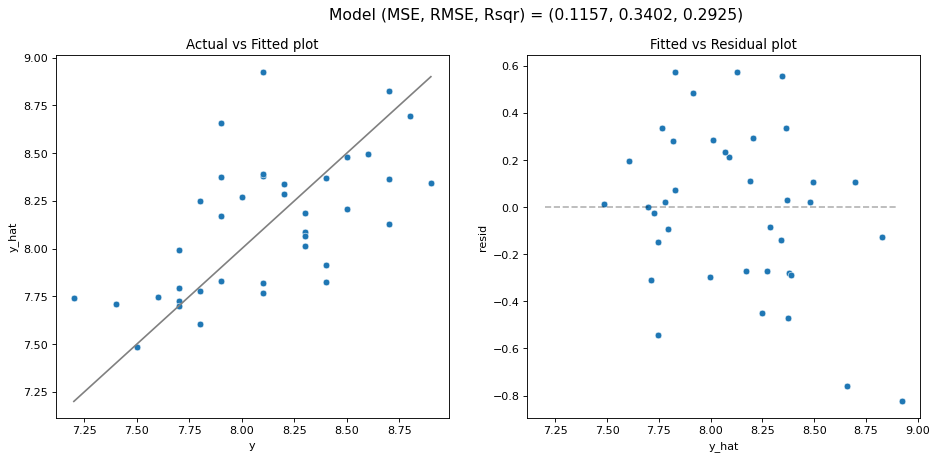

(0.1157213524498017, 0.3401784126745871, 0.29254177418495486)

In [386]:
#To be deleted in final report
#Linear Regression Accuracy
model_fit(lm, X_test, y_test, plot = True)

We define the following function which will return to us a dataframe showing the features with the largest coefficients in our fitted model. This allows us to easily interpret the results of our models.  

In [387]:
def get_impt_features(pipeline, input_df, k, positive = False):
    '''
        Get k most important features with the largest model coefficients (by absolute value if positive = True)
    '''
    mean = get_coefs(pipeline)[0]
    coefs = get_coefs(pipeline)[1:]
    
    if positive == True: 
        impt_idx = np.argsort(-coefs)[:k]
    else: 
        impt_idx = np.argsort(-np.abs(coefs))[:k]
        
    features = ['Intercept'] + list(pipeline[:-1].get_feature_names_out(input_df.columns)[impt_idx])
    coefficients = [mean] + list(coefs[impt_idx])
    
    return pd.DataFrame({
        'Features': features,
        'Coefficients': coefficients
    })
    

In [388]:
#Delete in final? 
get_impt_features(lm, X_train, 15)

,Features,Coefficients
0,Intercept,8.286081e+00
1,spring,4.055976e+12
2,autumn,3.999640e+12
3,winter,3.564678e+12
4,Halsted Sullivan wri,1.223572e+11
5,Warren Lieberstein wri,-1.223572e+11
6,Gene Stupnitsky wri,3.838196e+09
7,Lee Eisenberg wri,-3.838196e+09
8,n_lines,1.573199e-01
9,Paul Feig dir,1.422272e-01


Below we include our basic Ridge-Regression model, before tuning to find the parameter value which gives a model with the lowest root-mean-squared-error value.  

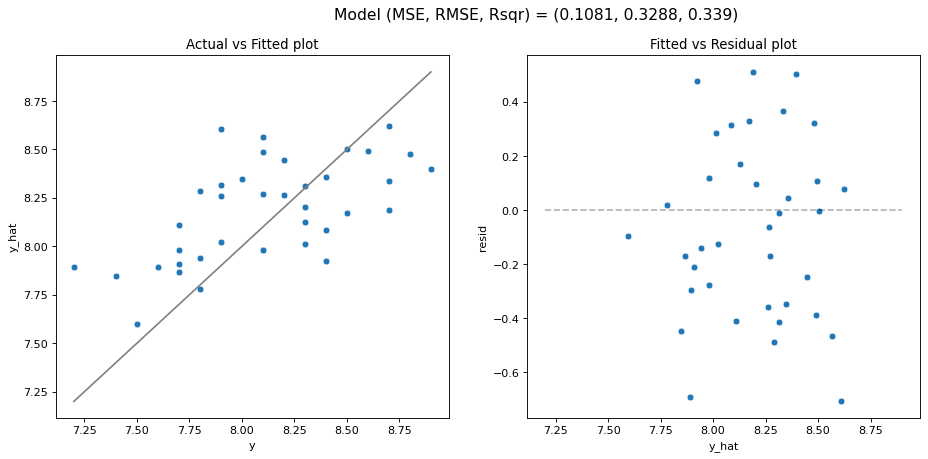

(0.10811645608618152, 0.328810669057714, 0.3390340279913373)

In [389]:
# First attempt at Ridge Regression 
from sklearn.linear_model import Ridge

#Setting alpha value
a = 100

#Fitting the ridge regression model to the training set
ridge_scaled = make_pipeline(
    StandardScaler(),
    Ridge(alpha = a)
).fit(X_train, y_train)

#Testing the ridge regression model on the testing set
model_fit(ridge_scaled, X_test, y_test, plot = True)


In [390]:
#We should probably look at coeffs for the optimised alpha value implementation. 
#get_impt_features(ridge_scaled, X_train, 15, positive = True)

{'ridge__alpha': 187.31218697829715}


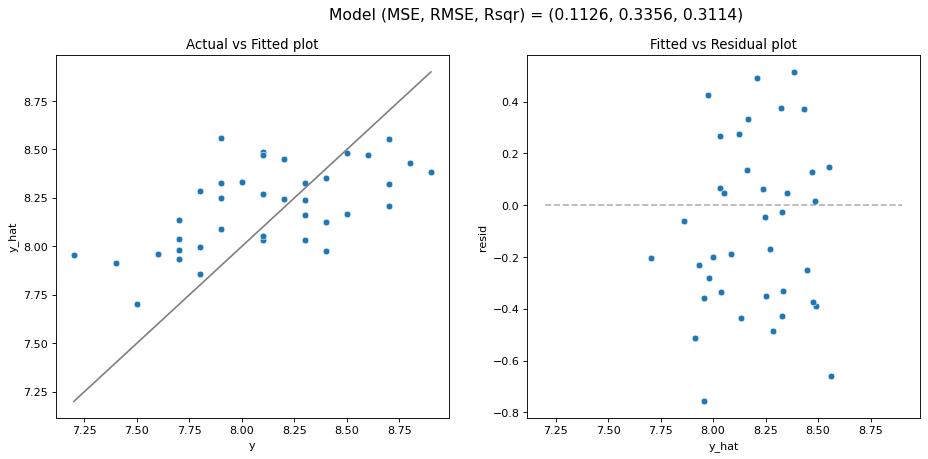

(0.11264408975571845, 0.3356249242170767, 0.31135450631982453)

In [394]:
#We implement parameter tuning using the grid search method given in Workshop 5

alphas = np.linspace(0, 300, num=600)

#Searching the parameter values for the one that gives best RMSE
gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)
# Note: We have already scaled the numerical data, but including the standard scaler in the model pipeline
# results in better predictive performance below. This may be due to benefit from scaling the columns 
# of encoded categorical variables, each of which contains a varying number of 1s vs 0s. 

# Fitting and evaluating the model with the best parameter choice
gs.fit(X_train, y_train)
print(gs.best_params_)
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

When we implemented the grid search for alpha between 0 and 60 as in the Week 5 Workshop, we found that the best alpha value was being returned as 60. Hence we increased the search range and found an optimal value of 187.3. 

The R-suqared and RMSE values for this best-alpha-value implementation are actually slightly worse than the results when alpha = 100. However, our optimised alpha value was the one deemed best during 5-fold cross-validation of our training set. So we think that the model using the tuned alpha value would perform better on average on other testing sets or new observations. 

In [397]:
get_impt_features(gs.best_estimator_, X_train, 20)


,Features,Coefficients
0,Intercept,8.286486
1,n_lines,0.071713
2,n_directions,0.050847
3,Other writers,-0.045466
4,words_Erin,-0.044915
5,air_year,-0.042018
6,Paul Feig dir,0.034631
7,Greg Daniels wri,0.033027
8,words_Michael,0.031624
9,Paul Lieberstein wri,0.027708


Our model coeffiecents tell us that total number of lines is a strong positive predictor of episode rating, and that this is by far the strongest predictor of episode performance. Number of directions is also returned as a slightly less strong positive perdictor. 

Characters whose numbers of scripts have relatively large positive corresponding coefficients include Michael, Stanley and Creed, with Michael the most positive. This makes sense because through research we found that Michael left the series at season 8, and season 8 was indicated to be remarkably less popular than other seasons in our earlier data exploration. These coefficients are each of magnitude two or three times less than that of number of lines, so our recommendation to include them in a new episode is secondary. It seems that the audience does not want Erin to talk much as her number of scripts has the most negative coefficient among those of all characters. However, through manually exploration we found that Erin's first presence in this series is at season 5. Considering the decreasing tendency of the series' overall popularity over time indicated by the negative coefficient of air_year, Erin's negative effects may not be attributed to the character itself, but to the overall quality. We also see that some of the most famous charaters Ryan, Andy, Dwight and Darryl have small but negative coefficents. Perhaps this indicates that regular episodes with the most common characters is tend to do less well. 

Greg Daniels, Paul Lieberstein and B.J. Novak are highlighted as writers with positive coefficents. Examining the database manually, we see that these writers do consistently produce good episodes. Paul Feig and Greg Daniels are highlighted as the directors with the most positive coefficients. Similarly, when we examine the data manually we can see that these directors produce consistently good episodes. Another thing to note is that the varible 'Other writers' has a very high negative effects, which might imply that the writers having experiences in this series are tended to produce better episodes.

The variable representing the season spring has a small positive coefficient, hence this may be an optimal time to release a new episode. 

Overall, our main recommendation to the studio is to write a new episode with a lot of dialogue. We can make further recommendations including:
- to hire Greg Daniels, Paul Lieberstein or B.J. Novak as writers and Paul Feig or Greg Daniels as director
- to have more conversations arranged for Michael, Stanley or Creed
- to involve lots of side-characters in the new episode, possibly a reunion special
- release the episode in spring

However, these further recommendations are significantly less reliable. The corresponding coefficients are so small that it is not necissarily justified to hire or rule-out writers based on this. Taking on the recommendation to involve many characters, or publish the episode in spring would be harmless. But it might be unfair to make hiring decisions based on minute differences in model coefficients which can't reflect every aspect of a writer/director's individual talent. 

In [31]:
#We maybe should remove this and just describe that we tried it but model performance wasn't any better than
# modelling rating directly

#Trying out total votes as a dependent variable 
# This might not work out because rating has higher correlation with more variables

#Creating feature and response arrays  
tvX_scaled = np.delete(X_scaled, 1, 1) #object = 1, axis = 1
tv = X_scaled[:,1]

#Splitting into training and testing sets 
tvX_train, tvX_test, tvy_train, tvy_test = train_test_split(tvX_scaled, tv, test_size = 0.3, random_state = 42)

linreg = LinearRegression()
lmtv = linreg.fit(tvX_train, tvy_train)

model_fit(lmtv, tvX_test, tvy_test, plot = True)

#I think something is still wrong with the model but hopefully when we fix it above it'll carry through


ValueError: Shape of passed values is (186, 52), indices imply (186, 53)

In [40]:
#Polynomial regression model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(
    PolynomialFeatures(degree = 3),
    LinearRegression()
)

print(poly_model)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])


In [41]:
poly_reg = poly_model.fit(X_train, y_train)

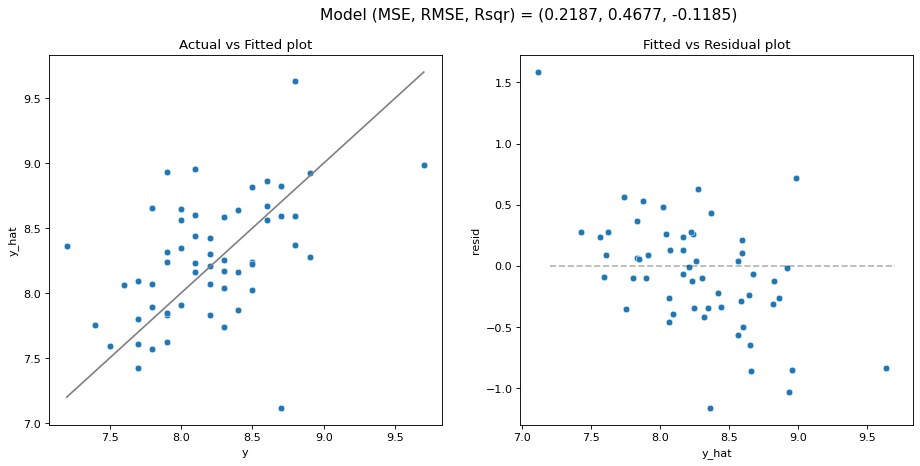

(0.21870935894917817, 0.46766372421770985, -0.11853185744161343)

In [42]:
#Degree 3 Polynomial Regression
model_fit(poly_reg, X_test, y_test, plot=True)
#Degree 2 Polynomial is even worse with R^2 -0.381

In [43]:
get_impt_features(poly_reg, X_train, 15)

,Features,Coefficients
0,n_lines Kevin char Ken Kwapis dir,0.011614
1,n_lines^2 Andy char,0.011648
2,Kelly char Oscar char Stanley char,0.011730
3,n_lines Oscar char Stanley char,-0.011775
4,n_speak_char Oscar char Paul Lieberstein wri,0.011951
5,Kelly char Michael char spring,0.012259
6,n_speak_char Oscar char summer,0.012292
7,n_speak_char Erin char Paul Lieberstein wri,0.013093
8,Andy char Stanley char summer,0.013161
9,n_lines n_speak_char air_year,-0.013936


8.253568306498074


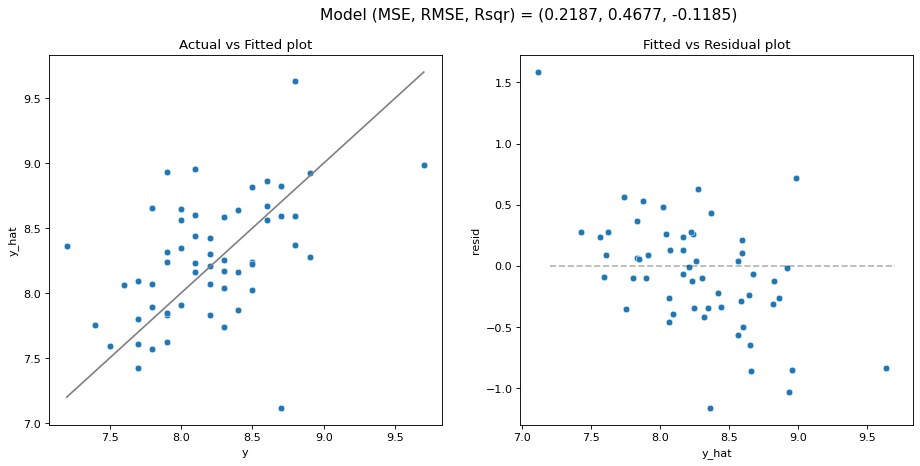

(0.21870935894917817, 0.46766372421770985, -0.11853185744161343)

In [44]:
print(poly_reg.steps[1][1].intercept_) # second subset is necessary here because 
                                       # each step is a tuple of a name and the 
                                       # model / transform o
                                       
                                       
model_fit(poly_reg, X_test, y_test, plot=True)


In [45]:
#Polynomial Ridge Regression
a = 0.1

poly_ridge = make_pipeline(
    PolynomialFeatures(degree = 2),
    StandardScaler(),
    Ridge(alpha = a)
)

poly_ridge.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.1))])

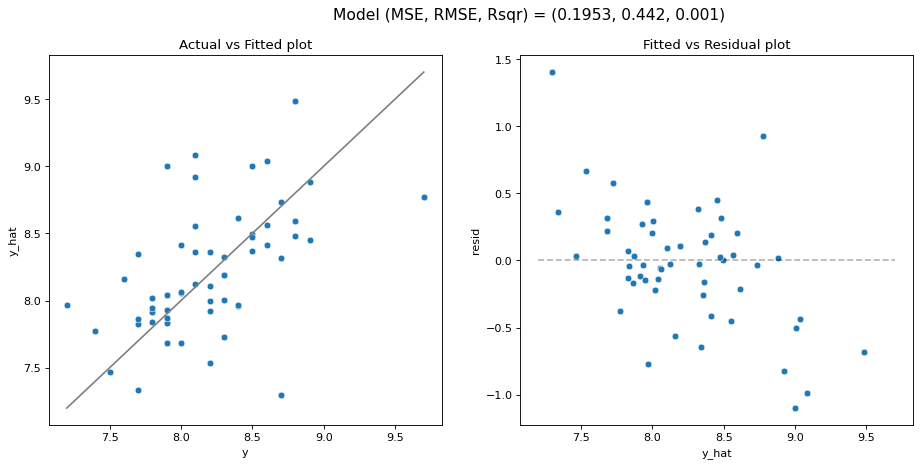

(0.19533463053070918, 0.44196677536972073, 0.0010120821534855828)

In [46]:
#Ploynomial Ridge Regression
model_fit(poly_ridge, X_test, y_test, plot=True)

In [47]:
get_impt_features(poly_ridge, X_train, 30)

,Features,Coefficients
0,Andy char summer,0.032658
1,Michael char Paul Lieberstein wri,-0.032967
2,n_directions Darryl char,0.033802
3,Toby char Ken Kwapis dir,0.034220
4,Darryl char Stanley char,-0.034438
5,Justin Spitzer wri winter,0.034517
6,Phyllis char Brent Forrester wri,-0.035822
7,Michael char Stanley char,0.035888
8,Creed char Daniel Chun wri,-0.035993
9,Oscar char Daniel Chun wri,-0.035993


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=8.48975e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.8857e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=1.58526e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


{'ridge__alpha': 60.0}


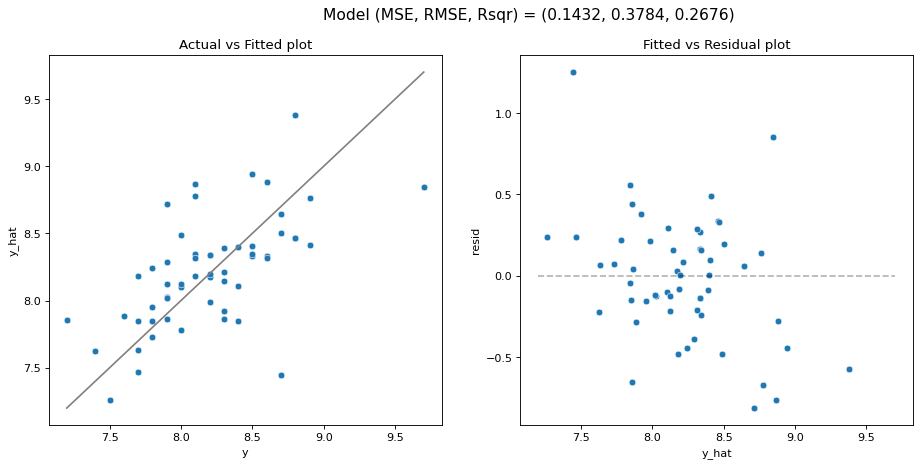

(0.14320745325661846, 0.37842760636166395, 0.2676029070716164)

In [48]:
#Tuning Alpha for Polynomial Ridge Regression
alphas = np.linspace(0, 60, num=200)

gs = GridSearchCV(
    make_pipeline(
        PolynomialFeatures(degree = 2),
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_mean_squared_error"
)

gs.fit(X_train, y_train)
print(gs.best_params_)
model_fit(gs.best_estimator_, X_test, y_test, plot=True)


In [44]:
poly_ridge_coefs = get_coefs(poly_ridge)

quadratic is good, cubic is worse. could do a plot of degree against an accuracy metric or cross validation to show that quadratic is the right choice.

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from